In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import geopandas as gpd
from geopy.distance import geodesic
import seaborn as sns
from cartopy import crs as ccrs
from cartopy import feature as cfeature

In [37]:
PENGUIN_PATH = '../../data/penguin/'
MERGED_DATASET = '../../data/penguin/penguins_final_with_era5.csv'
FILES = os.listdir(PENGUIN_PATH)

# combine all datasets into one
df = pd.concat([pd.read_csv(os.path.join(PENGUIN_PATH, file)) for file in FILES if file.startswith('Dataset')])

df_with_era5 = pd.read_csv(MERGED_DATASET)

In [11]:
df.head()

,dataset_id,scientific_name,common_name,site_name,colony_name,lat_colony,lon_colony,device,bird_id,track_id,...,age,sex,breed_stage,breed_status,date_gmt,time_gmt,latitude,longitude,argos_quality,equinox
0,758,Pygoscelis adeliae,Adelie Penguin,South Orkney Islands,Signy Island/Gourlay,-60.73,-45.59,GPS,826,758_826_11743,...,adult,unknown,brood-guard,breeding,2011-12-21,20:06:22,-60.73143,-45.58620,NaN,NaN
1,758,Pygoscelis adeliae,Adelie Penguin,South Orkney Islands,Signy Island/Gourlay,-60.73,-45.59,GPS,826,758_826_11743,...,adult,unknown,brood-guard,breeding,2011-12-21,20:03:22,-60.73084,-45.58765,NaN,NaN
2,758,Pygoscelis adeliae,Adelie Penguin,South Orkney Islands,Signy Island/Gourlay,-60.73,-45.59,GPS,826,758_826_11743,...,adult,unknown,brood-guard,breeding,2011-12-21,20:00:22,-60.72873,-45.58206,NaN,NaN
3,758,Pygoscelis adeliae,Adelie Penguin,South Orkney Islands,Signy Island/Gourlay,-60.73,-45.59,GPS,826,758_826_11743,...,adult,unknown,brood-guard,breeding,2011-12-23,23:38:15,-60.73019,-45.58790,NaN,NaN
4,758,Pygoscelis adeliae,Adelie Penguin,South Orkney Islands,Signy Island/Gourlay,-60.73,-45.59,GPS,826,758_826_11743,...,adult,unknown,brood-guard,breeding,2011-12-23,23:35:15,-60.73012,-45.58730,NaN,NaN


In [9]:
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 dataset_id                0
scientific_name           0
common_name               0
site_name                 0
colony_name               0
lat_colony                0
lon_colony                0
device                    0
bird_id                   0
track_id                  0
original_track_id         0
age                       0
sex                       0
breed_stage               0
breed_status              0
date_gmt                  0
time_gmt                  0
latitude                  0
longitude                 0
argos_quality         99850
equinox              415643
dtype: int64


### High level descriptive analysis

In [12]:
# Pinguins tracked
unique_penguins = df['bird_id'].nunique()
print(f"Total unique penguins tracked: {unique_penguins}")

Total unique penguins tracked: 749


common_name
Adelie Penguin       247361
Chinstrap Penguin    114313
Gentoo Penguin        53969
Name: count, dtype: int64


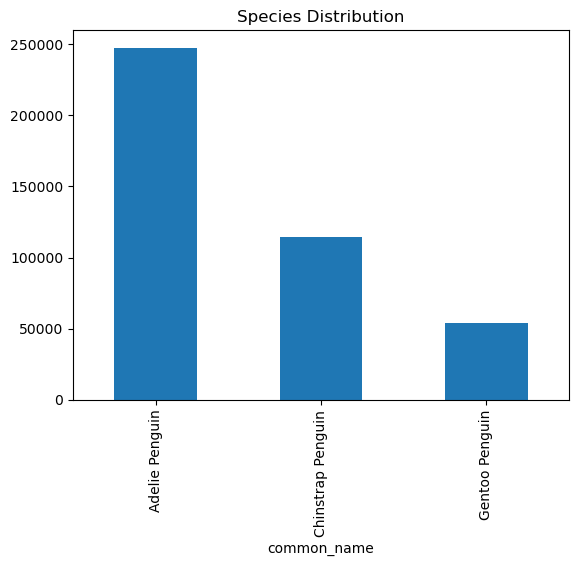

In [13]:
# Distribution of species
species_counts = df['common_name'].value_counts()

print(species_counts)
species_counts.plot(kind='bar', title='Species Distribution')
plt.show()

In [14]:
# Penguins per species
species_penguins = df.groupby('common_name')['bird_id'].nunique()
print(species_penguins)

common_name
Adelie Penguin       178
Chinstrap Penguin    393
Gentoo Penguin       178
Name: bird_id, dtype: int64


Data covers from 1996-10-30 00:00:00 to 2017-02-14 00:00:00


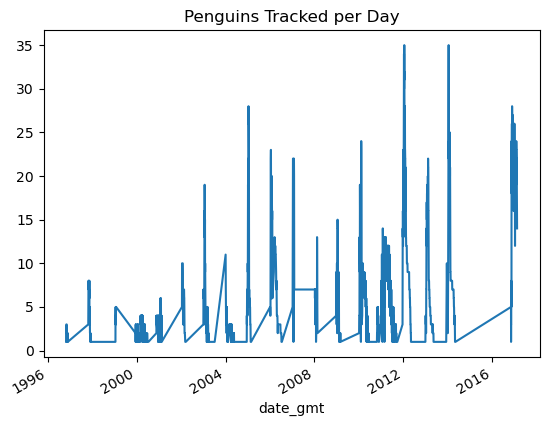

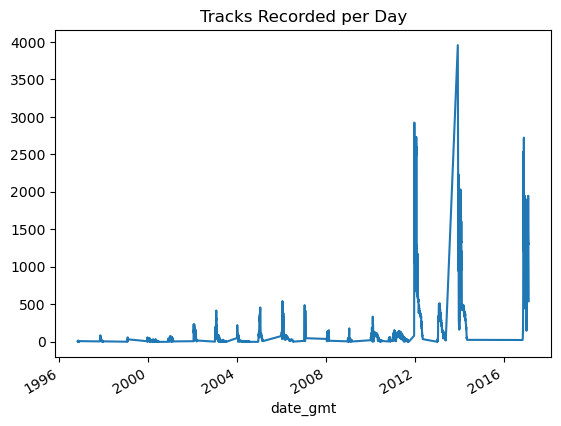

In [ ]:
# Date range
df['date_gmt'] = pd.to_datetime(df['date_gmt'])
print(f"Data covers from {df['date_gmt'].min()} to {df['date_gmt'].max()}")

# Number of penguins tracked per day
penguins_per_day = df.groupby('date_gmt')['bird_id'].nunique()
penguins_per_day.plot(title='Penguins Tracked per Day')
plt.show()

# Number tracks recorded per day
tracks_per_day = df.groupby('date_gmt').size()
tracks_per_day.plot(title='Tracks Recorded per Day')
plt.show()

### Movement and distance to colony

In [20]:
# calculate distance from colony for each track 
df['distance_from_colony'] = df.apply(lambda x: geodesic((x['lat_colony'], x['lon_colony']), (x['latitude'], x['longitude'])).km, axis=1)


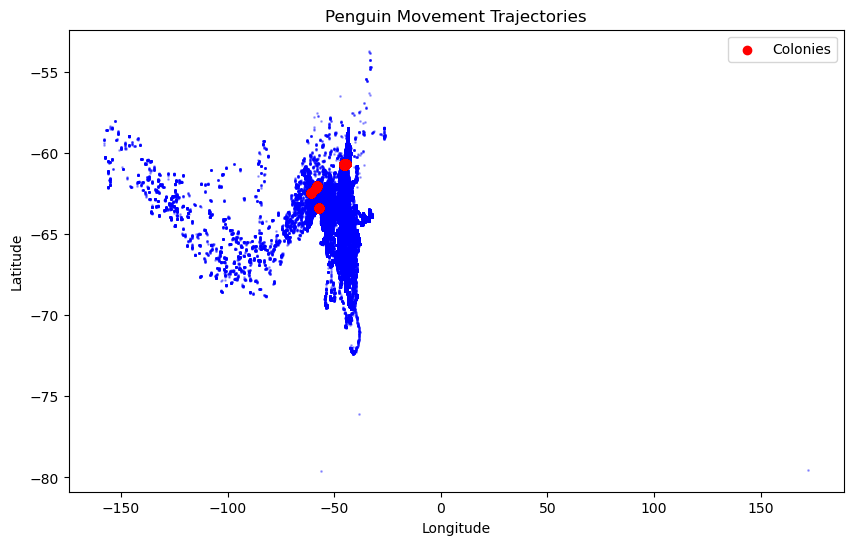

In [24]:
# plotting trajectories
plt.figure(figsize=(10, 6))
plt.scatter(df['longitude'], df['latitude'], c='blue', alpha=0.3, s=1)
plt.scatter(df['lon_colony'], df['lat_colony'], c='red', label='Colonies')
plt.title('Penguin Movement Trajectories')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

/opt/homebrew/anaconda3/envs/dataLiteracy/lib/python3.13/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/homebrew/anaconda3/envs/dataLiteracy/lib/python3.13/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/homebrew/anaconda3/envs/dataLiteracy/lib/python3.13/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


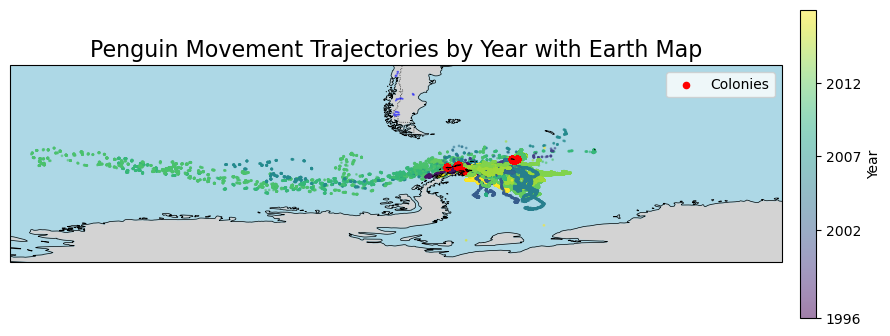

In [87]:
df['year'] = pd.to_datetime(df['date_gmt']).dt.year

# Create the map with a Cartopy projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add features to the map
ax.add_feature(cfeature.LAND, color='lightgray')  # Land in light gray
ax.add_feature(cfeature.OCEAN, color='lightblue')  # Ocean in light blue
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)  # Coastlines
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)  # Borders
ax.add_feature(cfeature.LAKES, color='blue', alpha=0.5)  # Lakes

# Set extent to focus on the region of interest
ax.set_extent([
    df['longitude'].min() - 5, df['longitude'].max() - 155,  # Longitude range
    df['latitude'].min() - 5, df['latitude'].max() + 15     # Latitude range
], crs=ccrs.PlateCarree())

# Scatter plot for trajectories, colored by year
sc = ax.scatter(
    df['longitude'], df['latitude'], c=df['year'], cmap='viridis', alpha=0.5, s=1, transform=ccrs.PlateCarree()
)

# Plot colony locations
ax.scatter(
    df['lon_colony'], df['lat_colony'], c='red', s=20, transform=ccrs.PlateCarree(), label='Colonies'
)

# Add legend
ax.legend(loc='upper right')

# Add color bar for the year
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02, shrink=0.5)
cbar.set_label('Year')
unique_years = np.unique(df['year'])
cbar.set_ticks(unique_years[0::5])
cbar.set_ticklabels(unique_years[0::5])

# Add title
ax.set_title('Penguin Movement Trajectories by Year with Earth Map', fontsize=16)

# Show the plot
plt.show()


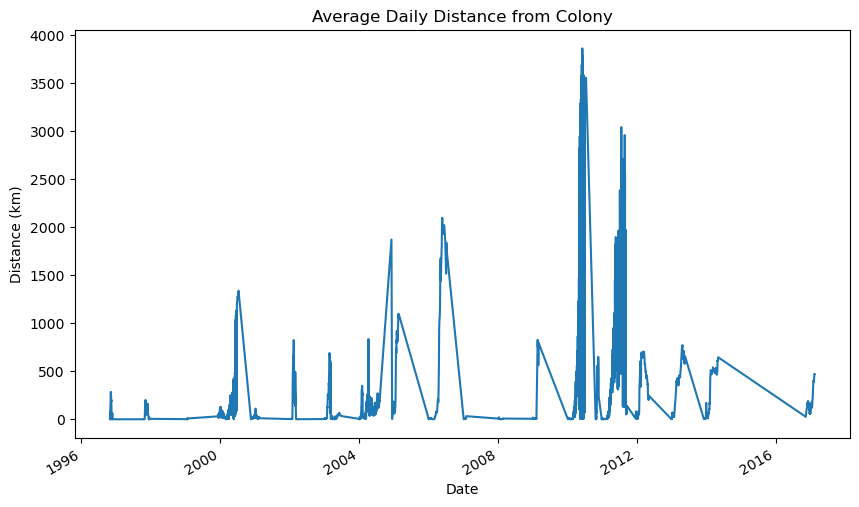

In [25]:
# movement over time
daily_avg_distance = df.groupby('date_gmt')['distance_from_colony'].mean()
daily_avg_distance.plot(title='Average Daily Distance from Colony', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Distance (km)')
plt.show()

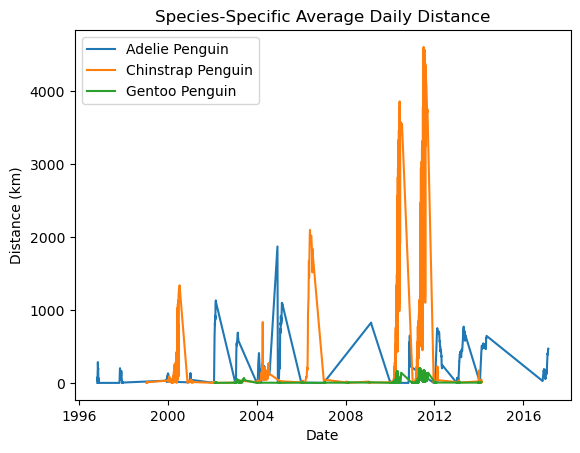

In [26]:
for species in df['common_name'].unique():
    subset = df[df['common_name'] == species]
    daily_avg = subset.groupby('date_gmt')['distance_from_colony'].mean()
    plt.plot(daily_avg, label=species)

plt.title('Species-Specific Average Daily Distance')
plt.xlabel('Date')
plt.ylabel('Distance (km)')
plt.legend()
plt.show()

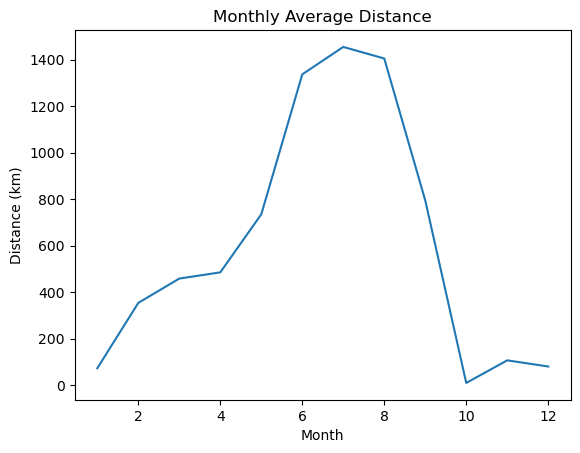

In [46]:
df['month'] = df['date_gmt'].dt.month
monthly_avg_distance = df.groupby('month')['distance_from_colony'].mean()
monthly_avg_distance.plot(title='Monthly Average Distance')
plt.xlabel('Month')
plt.ylabel('Distance (km)')
plt.show()


/var/folders/sd/ks8n1_fs1095g49dhzxt2zvr0000gn/T/ipykernel_25162/1103342096.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = penguin_data.groupby([colony_col, 'month', 'temp_band'])[dist_col].mean().reset_index()


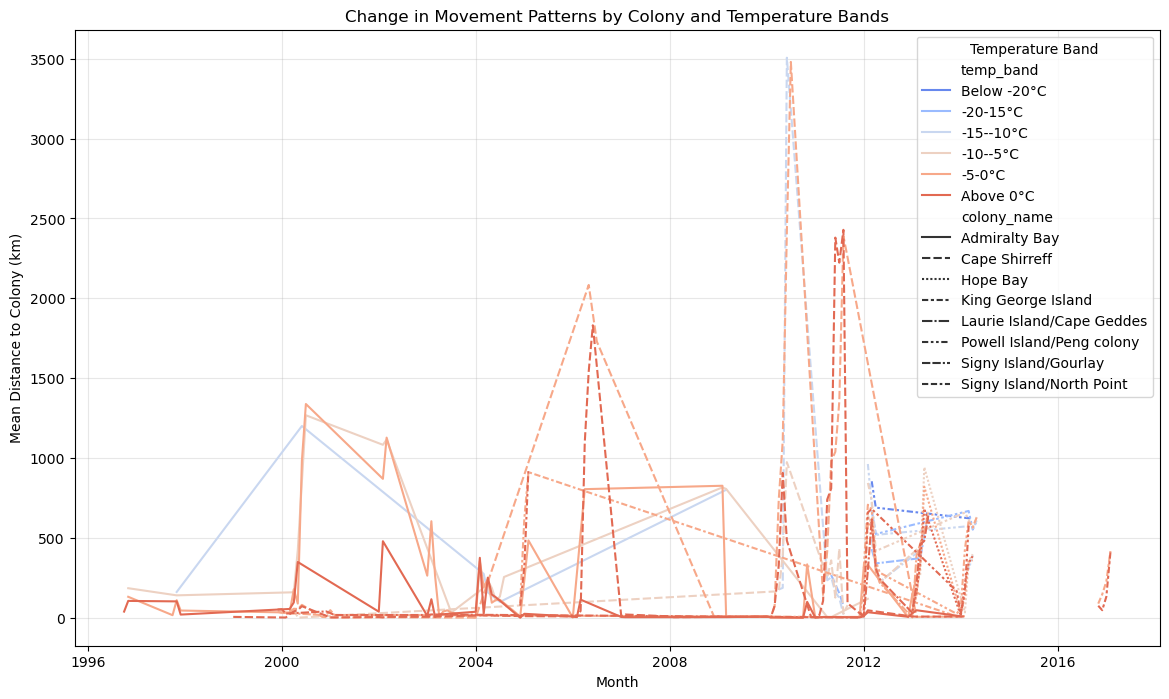

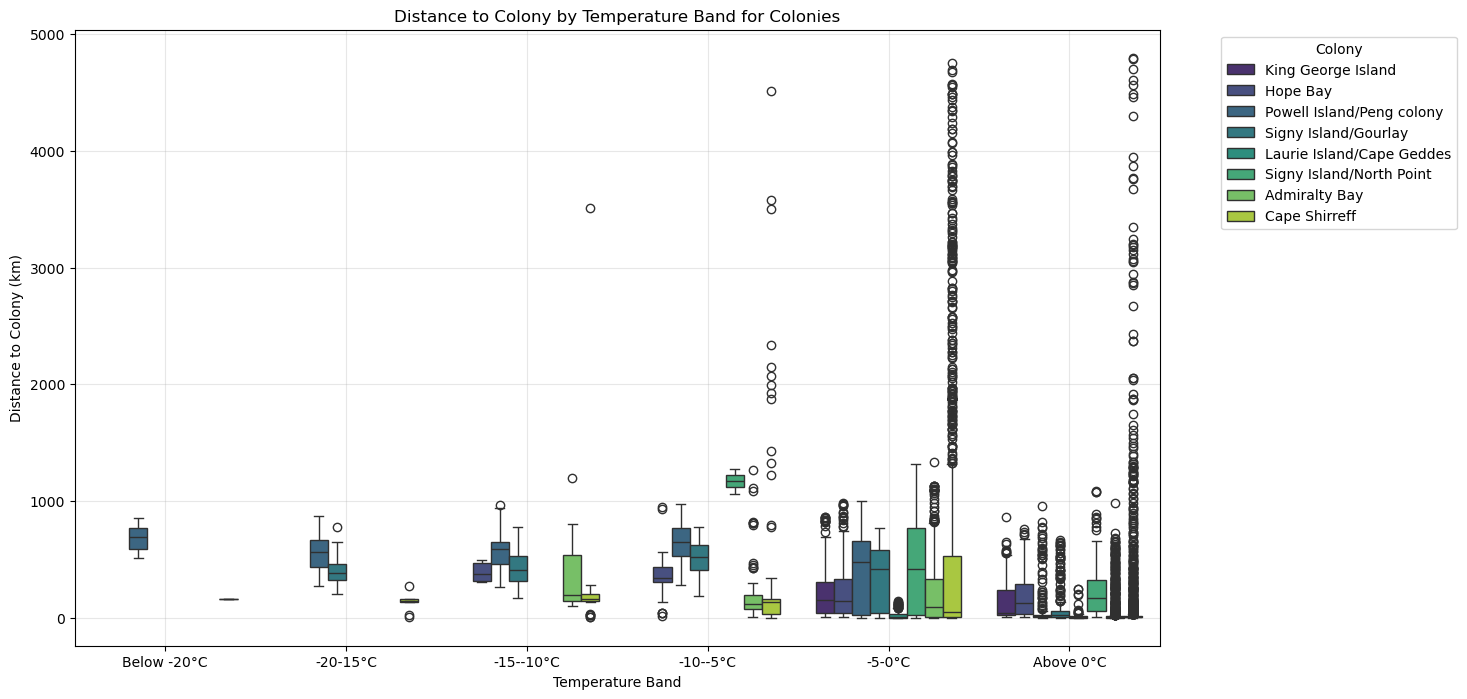

In [ ]:
def analyze_temperature_movement_patterns(penguin_data, temp_col, dist_col, date_col, colony_col):
    """
    Analyze how temperature and distance to colony interact over time, grouped by colony.
    
    Parameters:
    - penguin_data (pd.DataFrame): The analytical penguin dataset.
    - temp_col (str): Column name for temperature data.
    - dist_col (str): Column name for distance to colony data.
    - date_col (str): Column name for date data.
    - colony_col (str): Column name for colony names.
    """
    # Ensure proper datetime format
    penguin_data[date_col] = pd.to_datetime(penguin_data[date_col])
    penguin_data['month'] = penguin_data[date_col].dt.to_period('M')  # Monthly aggregation
    
    # Create temperature bands
    bins = [-np.inf, -20, -15, -10, -5, 0, np.inf]  # Adjust temperature ranges as needed
    labels = ['Below -20°C', '-20-15°C', '-15--10°C', '-10--5°C', '-5-0°C', 'Above 0°C']
    penguin_data['temp_band'] = pd.cut(penguin_data[temp_col], bins=bins, labels=labels)
    
    # Group data by colony and month
    grouped = penguin_data.groupby([colony_col, 'month', 'temp_band'])[dist_col].mean().reset_index()

    grouped['month'] = grouped['month'].dt.to_timestamp()
    
    # Plot 1: Line plot of movement over time by temperature bands for each colony
    plt.figure(figsize=(14, 8))
    sns.lineplot(
        data=grouped,
        x='month', y=dist_col, hue='temp_band', style=colony_col,
        palette='coolwarm', errorbar=None
    )
    plt.title("Change in Movement Patterns by Colony and Temperature Bands")
    plt.xlabel("Month")
    plt.ylabel("Mean Distance to Colony (km)")
    plt.legend(title="Temperature Band")
    plt.grid(alpha=0.3)
    plt.show()
    
    # Plot 2: Boxplot of movement by temperature bands for all colonies
    plt.figure(figsize=(14, 8))
    sns.boxplot(
        data=penguin_data,
        x='temp_band', y=dist_col, hue=colony_col,
        palette='viridis'
    )
    plt.title("Distance to Colony by Temperature Band for Colonies")
    plt.xlabel("Temperature Band")
    plt.ylabel("Distance to Colony (km)")
    plt.legend(title="Colony", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.show()

analyze_temperature_movement_patterns(
    penguin_data=df_with_era5,
    temp_col='t2m',
    dist_col='km_to_colony_mean',
    date_col='date_gmt',
    colony_col='colony_name'
)

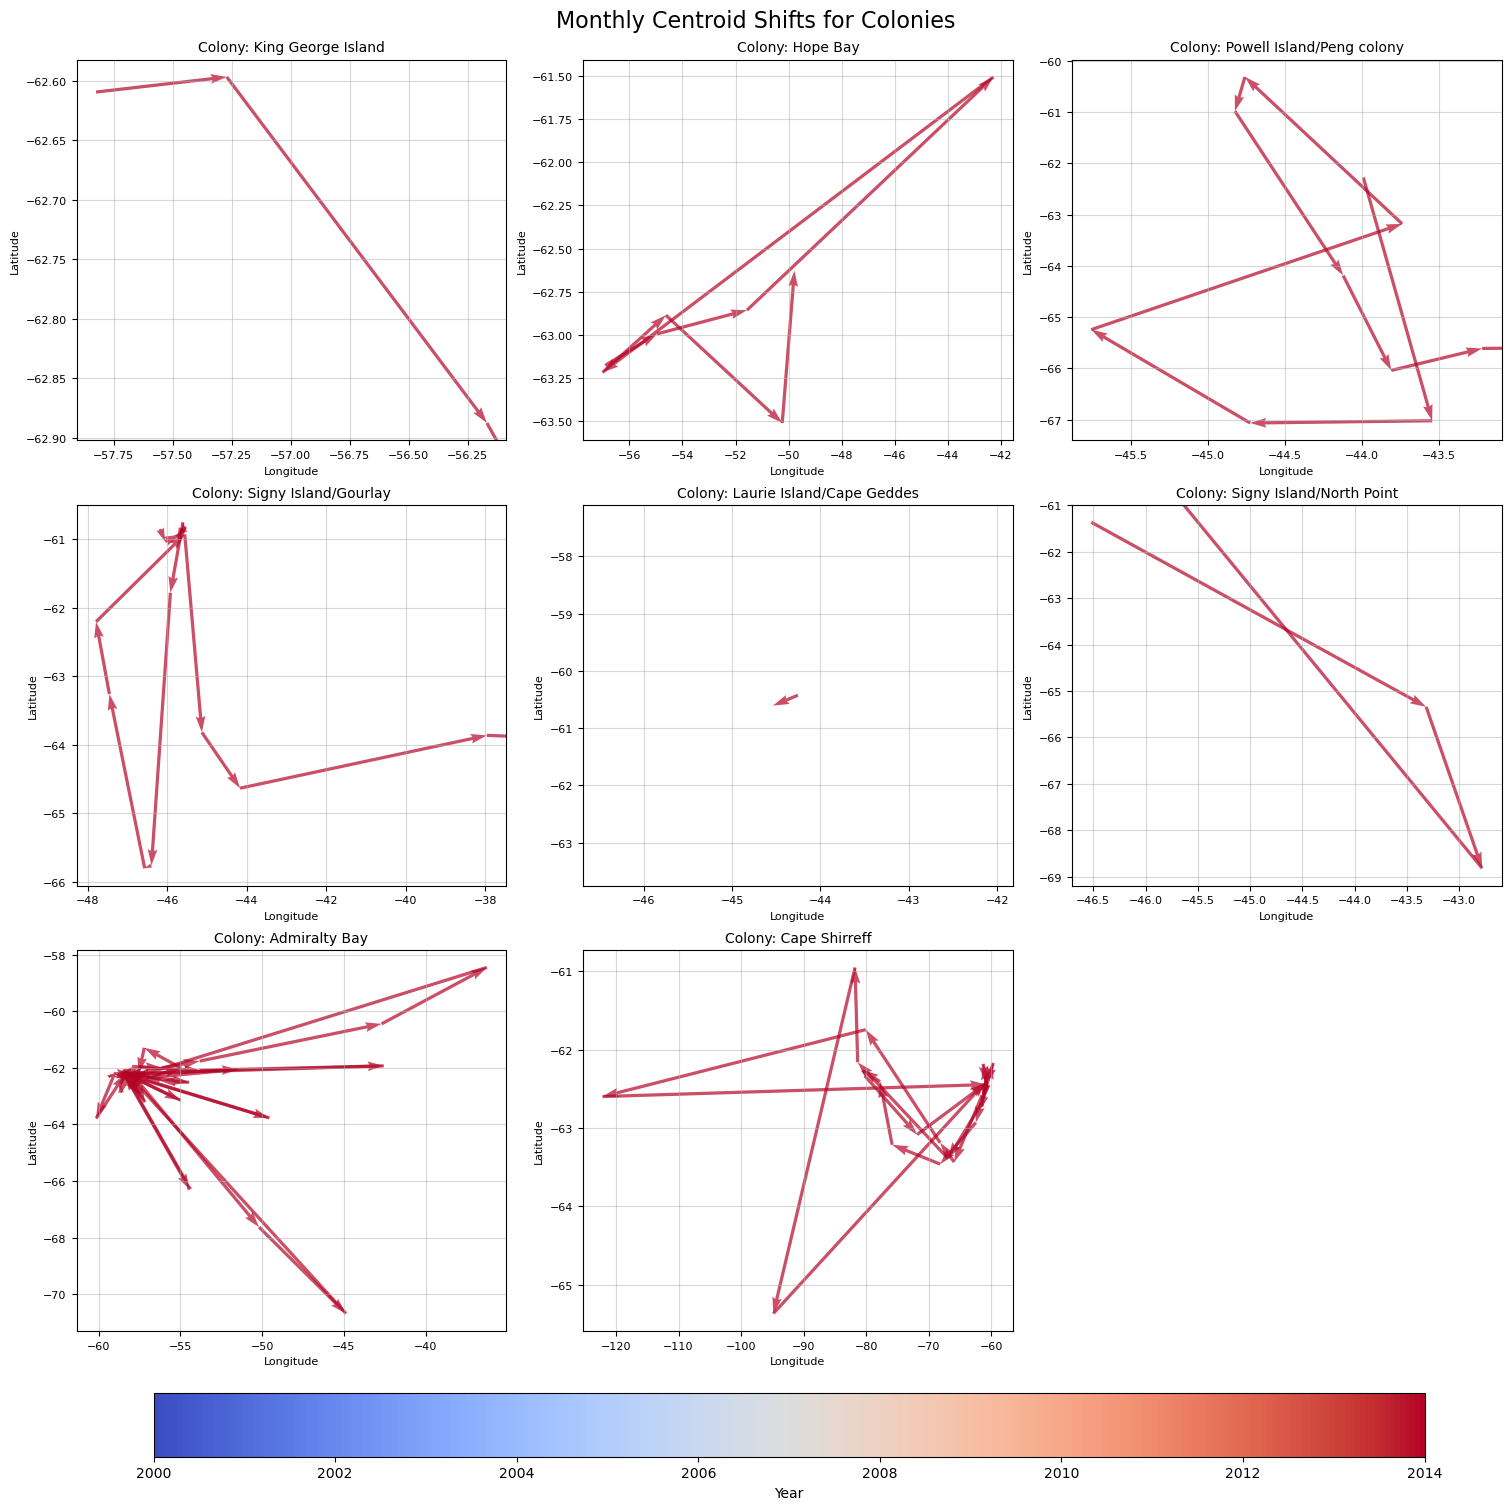

In [41]:
def visualize_colony_shifts_grid(data, lat_col, lon_col, time_col):
    """
    Create a grid of monthly centroid shift plots for all colonies, with minimalist styling.

    Parameters:
        data (pd.DataFrame): The dataset containing colony data.
        lat_col (str): Column representing latitude.
        lon_col (str): Column representing longitude.
        time_col (str): Column representing the date.

    Returns:
        None: Displays the plots in a grid.
    """
    # Ensure datetime format and extract year-month
    data[time_col] = pd.to_datetime(data[time_col], errors='coerce')
    data['year_month'] = data[time_col].dt.to_period('M')  # Format as YYYY-MM

    # Get unique colonies
    unique_colonies = data['colony_name'].unique()
    num_colonies = len(unique_colonies)

    # Set up grid layout (adjust columns for better layout)
    cols = 3
    rows = -(-num_colonies // cols)  # Ceiling division
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), constrained_layout=True)
    axes = axes.flatten()

    # Normalize year for color mapping
    cmap = sns.color_palette("coolwarm", as_cmap=True)

    # Create plots for each colony
    for idx, colony in enumerate(unique_colonies):
        ax = axes[idx]

        # Filter data for this colony
        colony_data = data[data['colony_name'] == colony].copy()

        # Group by year-month and calculate centroids
        centroids = colony_data.groupby('year_month').agg(
            centroid_lat=(lat_col, 'mean'),
            centroid_lon=(lon_col, 'mean')
        ).reset_index()

        # Convert year-month back to datetime for plotting
        centroids['year_month'] = centroids['year_month'].dt.to_timestamp()

        # Calculate shifts between consecutive months
        centroids['prev_centroid_lat'] = centroids['centroid_lat'].shift(1)
        centroids['prev_centroid_lon'] = centroids['centroid_lon'].shift(1)

        centroids['lat_shift'] = centroids['centroid_lat'] - centroids['prev_centroid_lat']
        centroids['lon_shift'] = centroids['centroid_lon'] - centroids['prev_centroid_lon']

        centroids['year'] = centroids['year_month'].dt.year
        centroids = centroids.dropna(subset=['lat_shift', 'lon_shift'])

        # Plot quiver for this colony
        for _, row in centroids.iterrows():
            ax.quiver(
                row['prev_centroid_lon'], row['prev_centroid_lat'],  # Start of arrow
                row['lon_shift'], row['lat_shift'],  # Shift values
                color=cmap(row['year']),
                angles='xy', scale_units='xy', scale=1, alpha=0.7, linewidth=0.5
            )

        ax.set_title(f'Colony: {colony}', fontsize=10)
        ax.set_xlabel('Longitude', fontsize=8)
        ax.set_ylabel('Latitude', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.grid(alpha=0.5)

    # Remove empty axes if colonies < grid size
    for ax in axes[num_colonies:]:
        ax.remove()

    # Add global colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=centroids['year'].min(), vmax=centroids['year'].max()))
    fig.colorbar(sm, ax=axes[:num_colonies], orientation='horizontal', fraction=0.05, pad=0.02, label='Year')

    plt.suptitle('Monthly Centroid Shifts for Colonies', fontsize=16)
    plt.show()

visualize_colony_shifts_grid(
    data=df_with_era5,
    lat_col='latitude_mean',
    lon_col='longitude_mean',
    time_col='date_gmt'
)

### Colony statistics

In [27]:
# get the number of different colonies
unique_colonies = df[['lat_colony', 'lon_colony']].drop_duplicates()
print(f"Total number of colonies: {unique_colonies.shape[0]}")

Total number of colonies: 8


In [89]:
# for every colony get the number of penguins, the timespan of data and the average distance from the colony
for i, colony in unique_colonies.iterrows():
    lat, lon = colony
    subset = df[(df['lat_colony'] == lat) & (df['lon_colony'] == lon)]
    num_penguins = subset['bird_id'].nunique()
    timespan = subset['date_gmt'].max() - subset['date_gmt'].min()
    avg_distance = subset['distance_from_colony'].mean()
    print(f"Colony at {lat}, {lon}: {num_penguins} penguins, {timespan.days} days, {avg_distance:.2f} km avg distance")

Colony at -60.73, -45.59: 87 penguins, 4910 days, 255.70 km avg distance
Colony at -62.03, -58.3: 30 penguins, 100 days, 184.76 km avg distance
Colony at -62.47, -60.79: 392 penguins, 5509 days, 260.26 km avg distance
Colony at -60.72, -45.02: 67 penguins, 849 days, 354.05 km avg distance
Colony at -62.18, -58.45: 229 penguins, 6288 days, 90.76 km avg distance
Colony at -60.67, -45.63: 19 penguins, 3302 days, 123.44 km avg distance
Colony at -60.68, -44.59: 59 penguins, 35 days, 43.02 km avg distance
Colony at -63.37, -57.17: 10 penguins, 467 days, 226.28 km avg distance


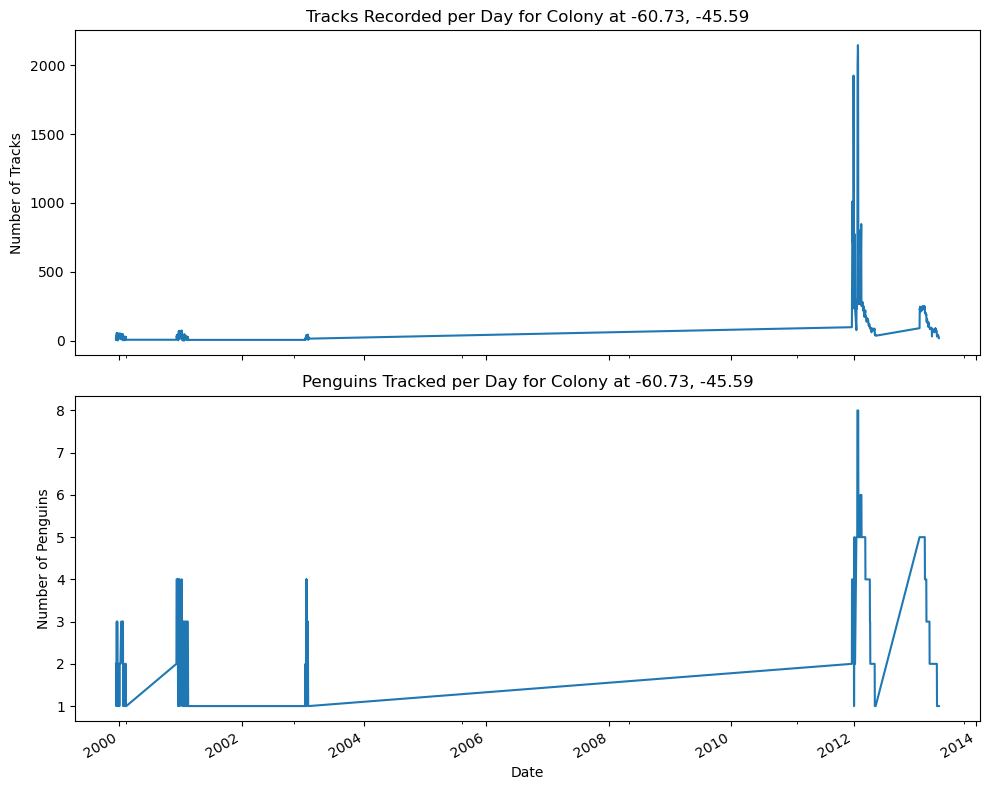

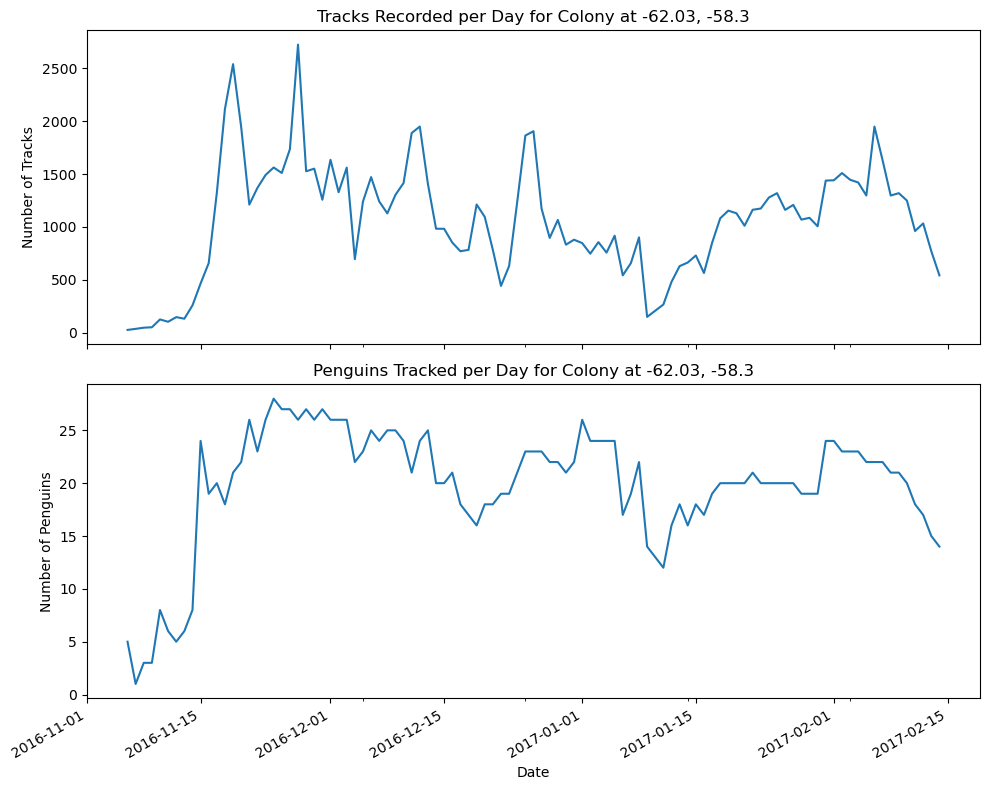

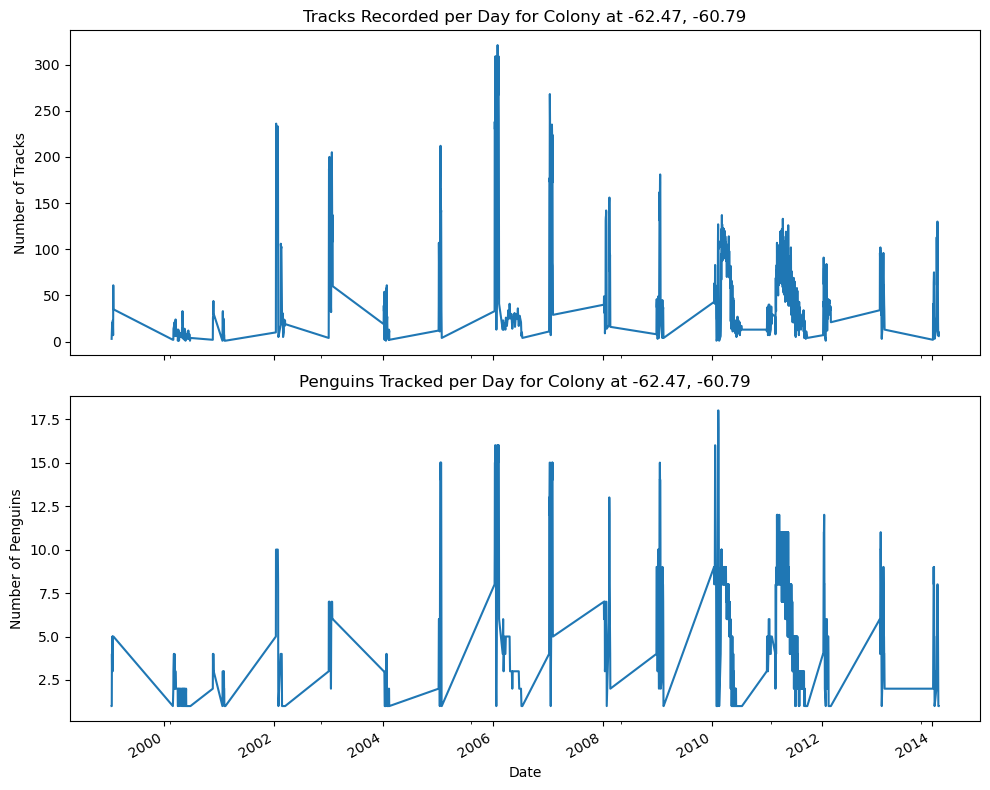

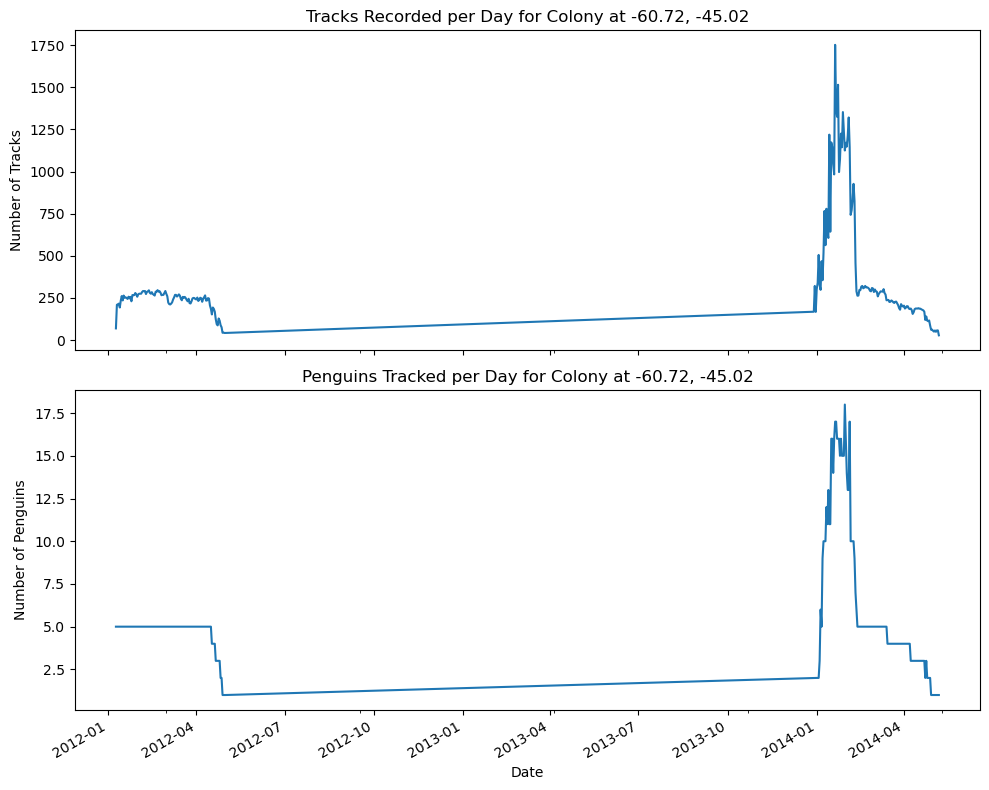

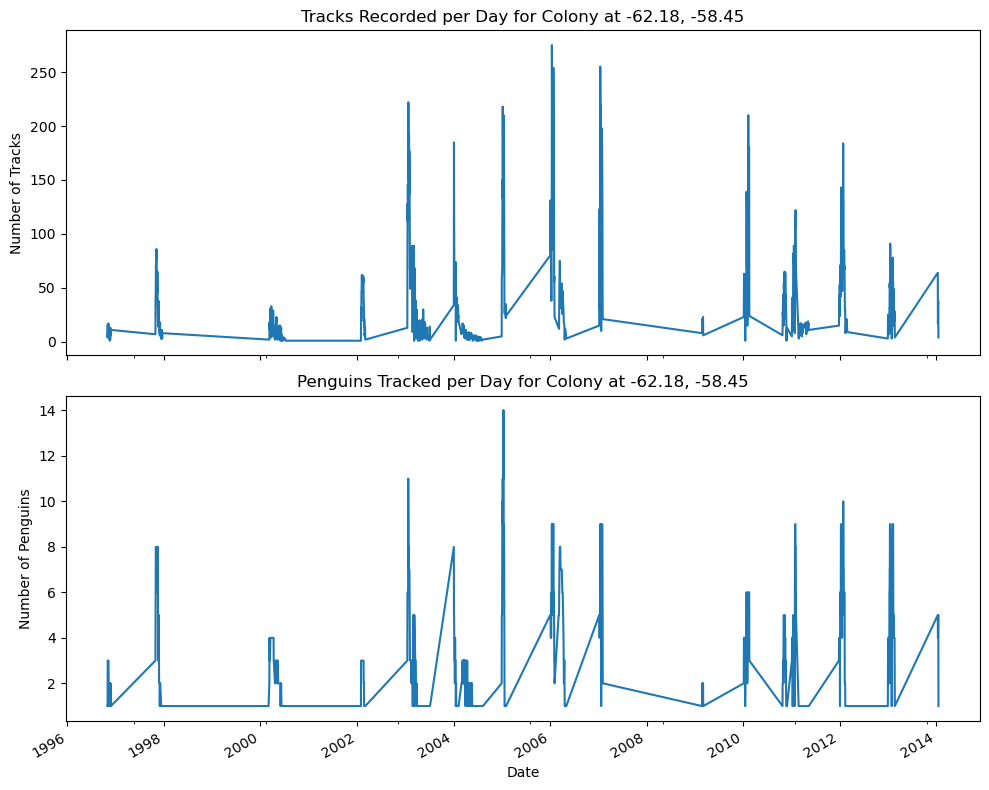

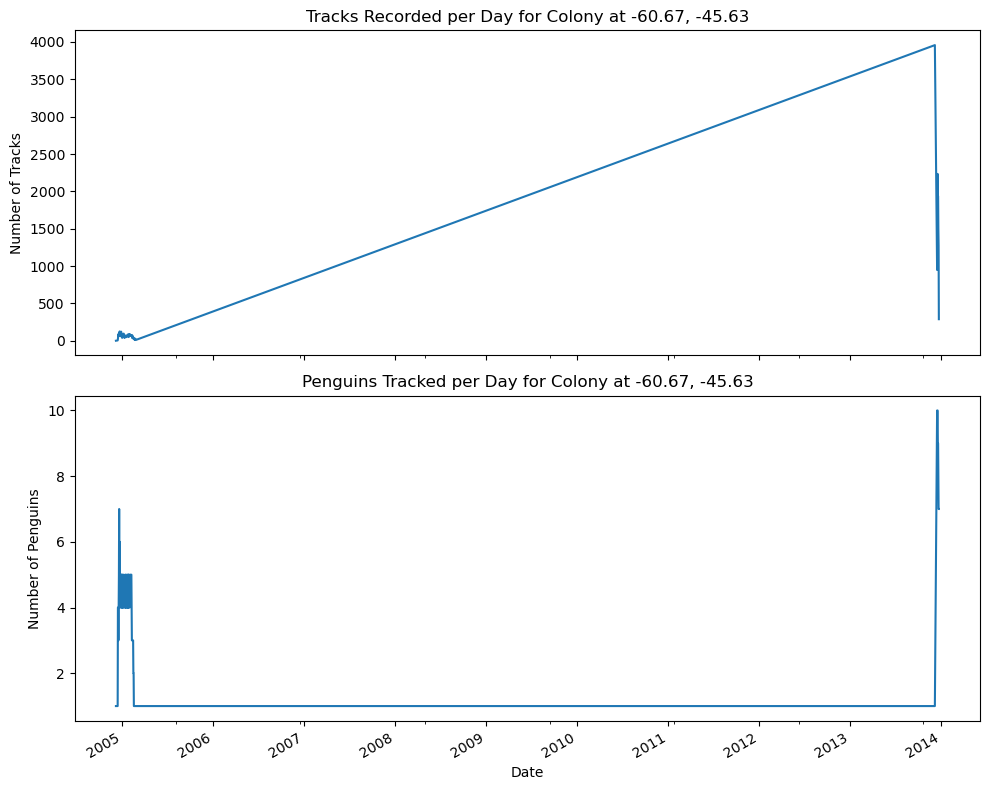

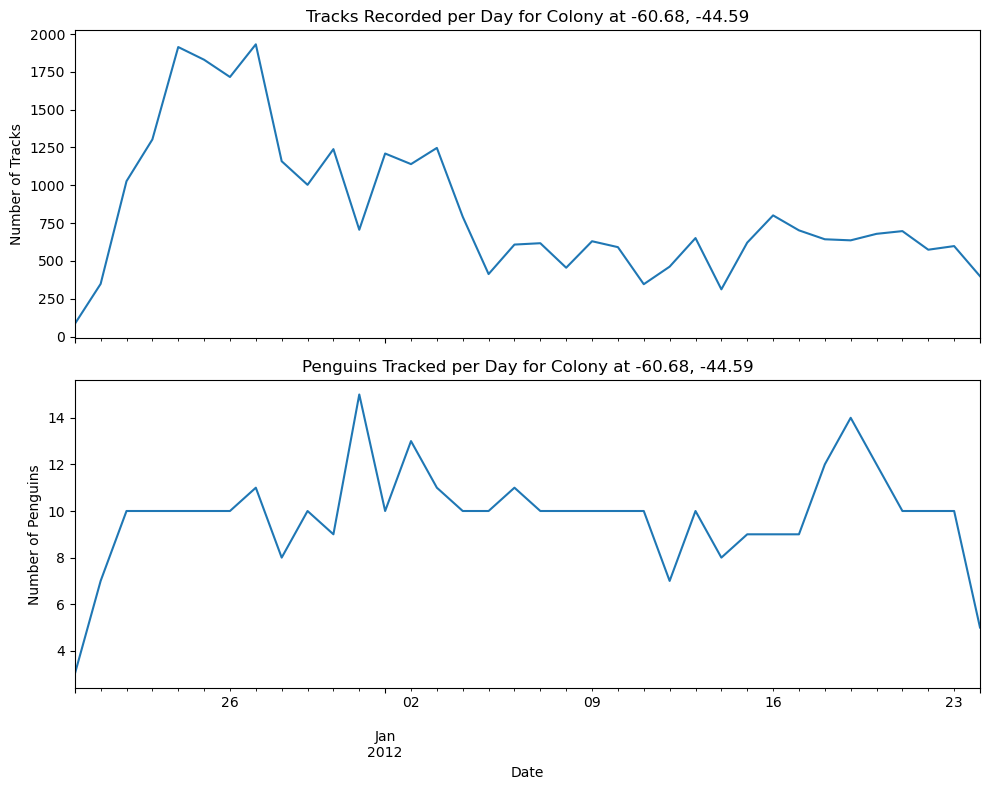

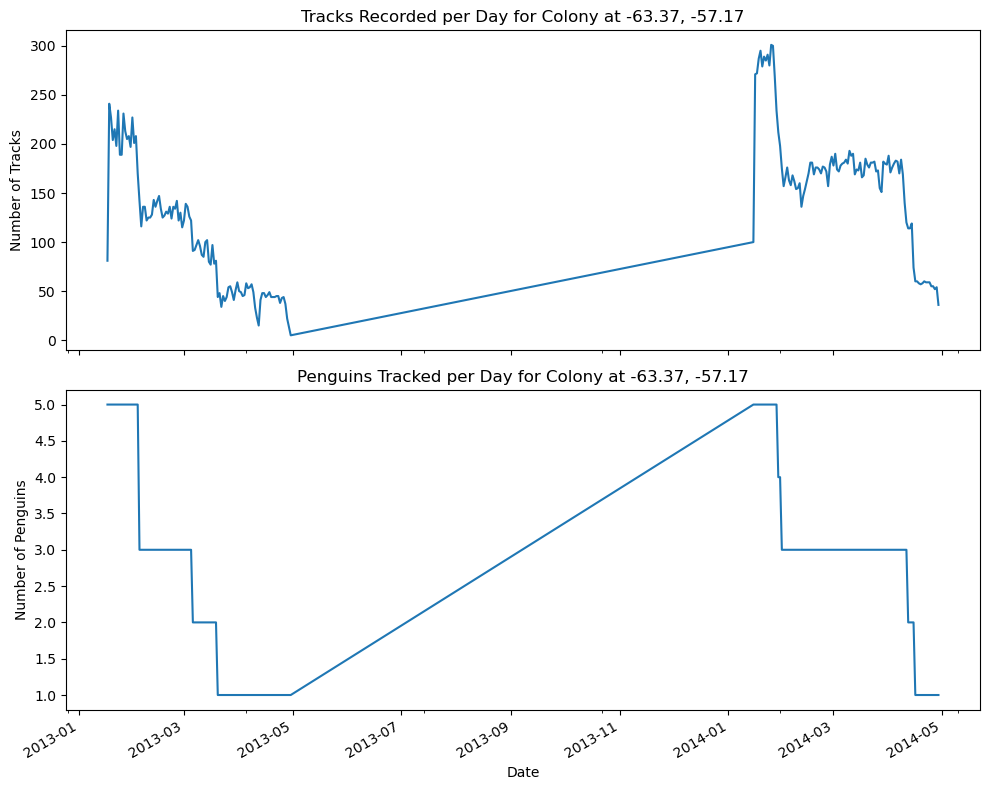

In [94]:
# for each colony plot the number of tracks recorded per day and the number of penguins tracked per day
for i, colony in unique_colonies.iterrows():
    lat, lon = colony
    subset = df[(df['lat_colony'] == lat) & (df['lon_colony'] == lon)]
    tracks_per_day = subset.groupby('date_gmt').size()
    penguins_per_day = subset.groupby('date_gmt')['bird_id'].nunique()
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # Plot tracks recorded per day
    tracks_per_day.plot(ax=ax[0], title=f'Tracks Recorded per Day for Colony at {lat}, {lon}')
    ax[0].set_ylabel('Number of Tracks')
    
    # Plot penguins tracked per day
    penguins_per_day.plot(ax=ax[1], title=f'Penguins Tracked per Day for Colony at {lat}, {lon}')
    ax[1].set_ylabel('Number of Penguins')
    
    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()

Average number of tracks recorded per penguin: 554.9305740987984


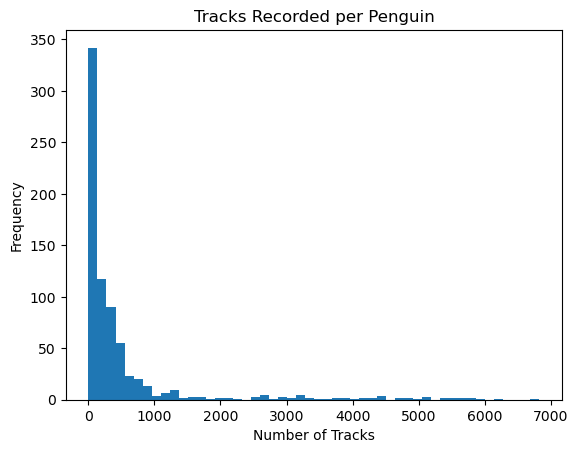

Average tracking frequency (hours): 35.39331777492477


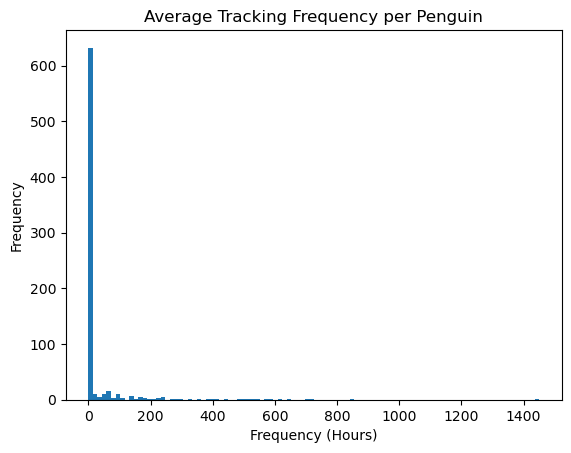

In [102]:
# whats the average number of tracks recorded per bird id and whats the frequency (so e.g. every hour, every day)
tracks_per_bird = df.groupby('bird_id').size()
print(f"Average number of tracks recorded per penguin: {tracks_per_bird.mean()}")
tracks_per_bird.plot(kind='hist', bins=50, title='Tracks Recorded per Penguin')
plt.xlabel('Number of Tracks')
plt.show()


df['date_gmt'] = pd.to_datetime(df['date_gmt'])

# Ensure time_gmt is a string
df['time_gmt'] = df['time_gmt'].astype(str)
df['datetime'] = pd.to_datetime(df['date_gmt'].dt.date.astype(str) + ' ' + df['time_gmt'])

# Sort the data by bird_id and datetime
df = df.sort_values(by=['bird_id', 'datetime'])

# Calculate time differences in seconds
df['time_diff'] = df.groupby('bird_id')['datetime'].diff().dt.total_seconds()

# Average time difference (frequency) per bird_id
average_frequency = df.groupby('bird_id')['time_diff'].mean() / 3600  # Convert to hours
print(f"Average tracking frequency (hours): {average_frequency.mean()}")
average_frequency.plot(kind='hist', bins=100, title='Average Tracking Frequency per Penguin')
plt.xlabel('Frequency (Hours)')
plt.show()